## To run this colab, press the "Runtime" button in the menu tab and then press the "Run all" button.

##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Recognize Flowers using Transfer Learning

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/examples/blob/master/community/en/flowers_tf_lite.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/examples/blob/master/community/en/flowers_tf_lite.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

In [ ]:
import tensorflow as tf
assert tf.__version__.startswith('2')

import os
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import clear_output
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

In [ ]:
tf.__version__

'2.2.0'

Sync With Kaggle Dataset 

In [ ]:
# Sync with Kaggle API
# Please uplaod your .json kaggle API
from google.colab import files
files.upload()

In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json # set permission

kaggle.json


In [ ]:
# Download dataset using Kaggle API
!kaggle datasets download -d ashishjangra27/face-mask-12k-images-dataset

 97% 321M/330M [00:11<00:00, 32.8MB/s]
100% 330M/330M [00:11<00:00, 29.6MB/s]


In [ ]:
# Unzip file 
!unzip 'face-mask-12k-images-dataset.zip' -d face_mask_image_dataset
clear_output()

## Setup Input Pipeline

Download the flowers dataset.

Use `ImageDataGenerator` to rescale the images.

Create the train generator and specify where the train dataset directory, image size, batch size.

Create the validation generator with similar approach as the train generator with the flow_from_directory() method.

In [ ]:
IMAGE_SIZE = 224
BATCH_SIZE = 64

datagen = tf.keras.preprocessing.image.ImageDataGenerator( 
	rescale=1./255,
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

train_generator = datagen.flow_from_directory(
    "/content/face_mask_image_dataset/Face Mask Dataset/Train",
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE)

val_generator = datagen.flow_from_directory(
    "/content/face_mask_image_dataset/Face Mask Dataset/Validation",
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE)

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [ ]:
for image_batch, label_batch in train_generator:
  break
image_batch.shape, label_batch.shape

((64, 224, 224, 3), (64, 2))

Save the labels in a file which will be downloaded later.

In [ ]:
print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels)

{'WithMask': 0, 'WithoutMask': 1}


In [ ]:
!cat labels.txt

WithMask
WithoutMask

## Create the base model from the pre-trained convnets

Create the base model from the **MobileNet V2** model developed at Google, and pre-trained on the ImageNet dataset, a large dataset of 1.4M images and 1000 classes of web images.

Let's instantiate an MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the `include_top=False` argument, we load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [ ]:
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


## FINE TUNING
I will freeze the convolutional base created from the previous step and use that as a feature extractor, add a classifier on top of it and train the top-level classifier.

In [ ]:
for layer in base_model.layers:
	layer.trainable = False

### Add a classification head

In [ ]:
# Mask and WithoutMask
dense = 2

In [ ]:
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense
from tensorflow.keras.models import Model

In [ ]:
headModel = base_model.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

print('Base model ready')

Base model ready


In [ ]:
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=base_model.input, outputs=headModel)

### Compile the model

You must compile the model before training it.  Since there are multiple classes, use a categorical cross-entropy loss.

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
______________________________________________________________________________________________

In [ ]:
checkpoint = ModelCheckpoint('model.{epoch:02d}-{val_loss:.2f}.h5',
                             monitor='val_loss',
                             verbose=0,
                             save_best_only=True,
                             mode='auto')

In [ ]:
print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

Number of trainable variables = 4


### Train the model

<!-- TODO(markdaoust): delete steps_per_epoch in TensorFlow r1.14/r2.0 -->

In [ ]:
epochs = 5

history = model.fit(train_generator, 
                    steps_per_epoch=len(train_generator), 
                    epochs=epochs, 
                    validation_data=val_generator, 
                    validation_steps=len(val_generator),
                    callbacks=[checkpoint])

Epoch 1/5
157/157 [==============================] - 413s 3s/step - loss: 0.0262 - accuracy: 0.9903 - val_loss: 0.0116 - val_accuracy: 0.9950
Epoch 2/5
157/157 [==============================] - 422s 3s/step - loss: 0.0215 - accuracy: 0.9925 - val_loss: 0.0131 - val_accuracy: 0.9925
Epoch 3/5
157/157 [==============================] - 420s 3s/step - loss: 0.0243 - accuracy: 0.9918 - val_loss: 0.0189 - val_accuracy: 0.9925
Epoch 4/5
157/157 [==============================] - 404s 3s/step - loss: 0.0199 - accuracy: 0.9933 - val_loss: 0.0110 - val_accuracy: 0.9975
Epoch 5/5
157/157 [==============================] - 405s 3s/step - loss: 0.0217 - accuracy: 0.9925 - val_loss: 0.0095 - val_accuracy: 0.9975


### Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNet V2 base model as a fixed feature extractor. 

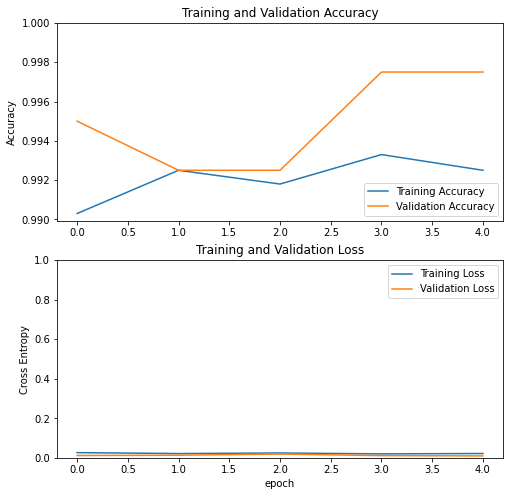

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

 ## Convert to TFLite

Saved the model using `tf.saved_model.save` and then convert the saved model to a tf lite compatible format.

In [ ]:
saved_model_dir = '/content/save/fine_tuning_mobilenetv2'
tf.saved_model.save(model, saved_model_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /content/save/fine_tuning_mobilenetv2/assets


INFO:tensorflow:Assets written to: /content/save/fine_tuning_mobilenetv2/assets


Download the converted model and labels

In [ ]:
from google.colab import files

files.download('model.tflite')
files.download('labels.txt')

In [ ]:
model.save('model.05-0.00.h5')

In [ ]:
!zip -r /content/fine_tuning_mobilenetv2.zip /content/save/fine_tuning_mobilenetv2
files.download("/content/fine_tuning_mobilenetv2.zip")

  adding: content/save/fine_tuning_mobilenetv2/ (stored 0%)
  adding: content/save/fine_tuning_mobilenetv2/saved_model.pb (deflated 92%)
  adding: content/save/fine_tuning_mobilenetv2/assets/ (stored 0%)
  adding: content/save/fine_tuning_mobilenetv2/variables/ (stored 0%)
  adding: content/save/fine_tuning_mobilenetv2/variables/variables.data-00000-of-00001 (deflated 9%)
  adding: content/save/fine_tuning_mobilenetv2/variables/variables.index (deflated 77%)


# Prediction
This step I going to predict the model that I already save which is 'model.05-0.00.h5'. We'll gonna see the result of prediction from some sample of data testing 

In [ ]:
import numpy as np
from tensorflow.keras.models import load_model
from keras.preprocessing import image
import matplotlib.pyplot as plt 

from google.colab import files

# Directory
from os import listdir

# Image Processing
from tensorflow.keras.preprocessing.image import load_img
from sklearn.utils import shuffle
from matplotlib import rcParams

Using TensorFlow backend.


In [ ]:
def loadImages(list_path):
    # return list of images

    # Based URL
    URL = "/content/face_mask_image_dataset/Face Mask Dataset/"
    loadedImages=[]

    # Read each Image and get to the list
    for path in list_path:
      print("[INFO] loading "+path+" dataset . . . ")
      imagesList = listdir(URL+path)
      temp = []
      for image in imagesList:
          # img = mpimg.imread(URL+path +"/"+ image)
          img = load_img(URL+path +"/"+ image, target_size=(224, 224))
          temp.append(img)
      loadedImages+=temp

    return loadedImages

In [ ]:

def class_result(list_predict):
    """
    Function to define class of shapes
    """
    list_predict = list_predict.tolist()
    if list_predict.index(max(list_predict)) == 0:
        return 'WithMask'
    elif list_predict.index(max(list_predict)) == 1:
        return 'WithoutMask'


def predict_class(img_name, model):
    """
    Function to predict new image
    """
    test_image = image.img_to_array(img_name)
    test_image = np.expand_dims(test_image, axis=0)
    test_image /= 255.
    result = model.predict(test_image)
    plt.figure(figsize=(3,3))
    plt.imshow(img_name)
    plt.show()
    print('Predicted : ', class_result(result[0]))

## Load testing data

In [ ]:
# Define URL for data test
df_test = loadImages(["Test/WithMask","Test/WithoutMask"])
df_test = shuffle(df_test, random_state=0)

[INFO] loading Test/WithMask dataset . . . 
[INFO] loading Test/WithoutMask dataset . . . 


### Show the example of testing data 

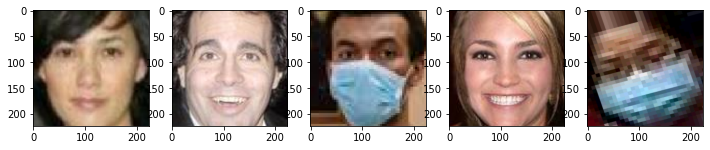

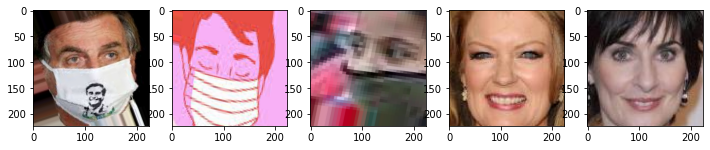

In [ ]:
# Show the example of image in data train
%matplotlib inline

shuffle(df_test)

n_image=5

# figure size in inches optional
rcParams['figure.figsize'] = 12 ,12

# display images
fig, ax = plt.subplots(1,n_image)

for i in range(n_image):
    ax[i].imshow(df_test[i]);

# display images
fig, ax = plt.subplots(1,n_image)

for i in range(n_image):
    ax[i].imshow(df_test[i+5]);

## Load Model

In [ ]:
# Load model
model = load_model('model.05-0.00.h5')

## Call predict function

### Try predict with 100 testing data

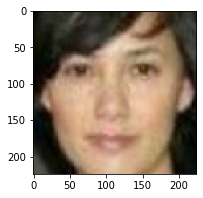

Predicted :  WithoutMask


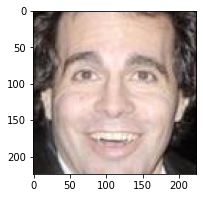

Predicted :  WithoutMask


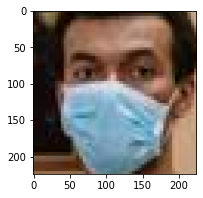

Predicted :  WithMask


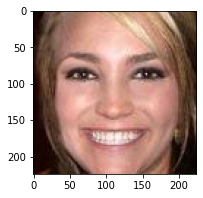

Predicted :  WithoutMask


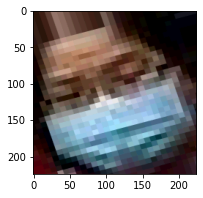

Predicted :  WithMask


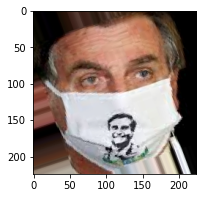

Predicted :  WithMask


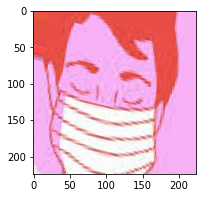

Predicted :  WithMask


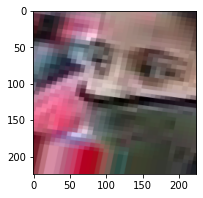

Predicted :  WithMask


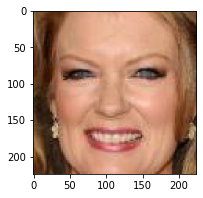

Predicted :  WithoutMask


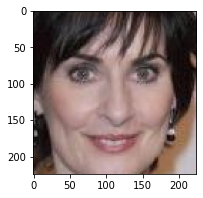

Predicted :  WithoutMask


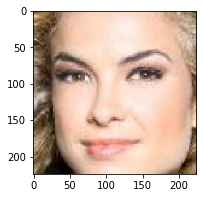

Predicted :  WithoutMask


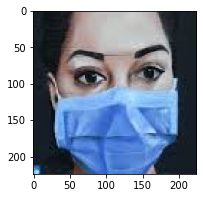

Predicted :  WithMask


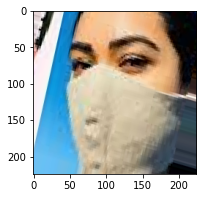

Predicted :  WithMask


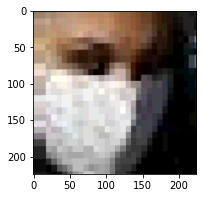

Predicted :  WithMask


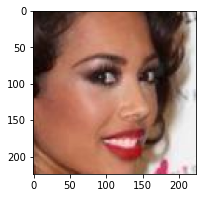

Predicted :  WithoutMask


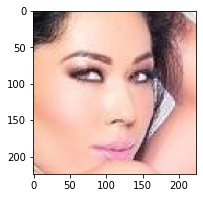

Predicted :  WithoutMask


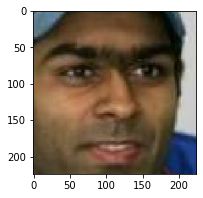

Predicted :  WithoutMask


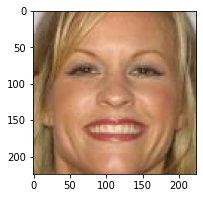

Predicted :  WithoutMask


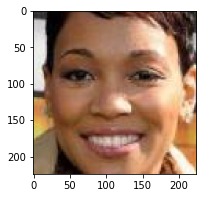

Predicted :  WithoutMask


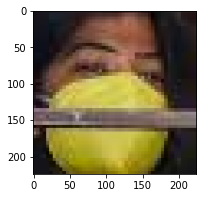

Predicted :  WithMask


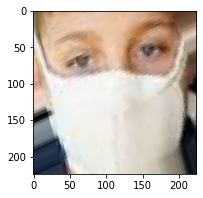

Predicted :  WithMask


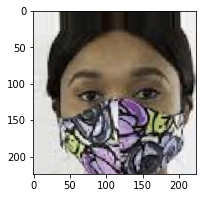

Predicted :  WithMask


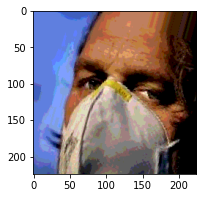

Predicted :  WithMask


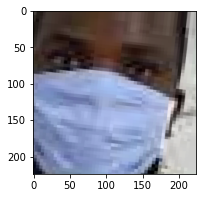

Predicted :  WithMask


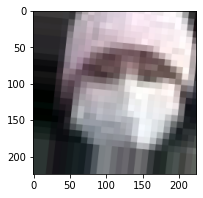

Predicted :  WithMask


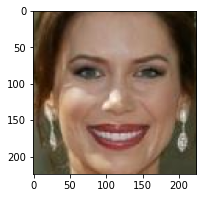

Predicted :  WithoutMask


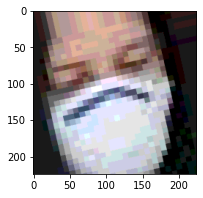

Predicted :  WithMask


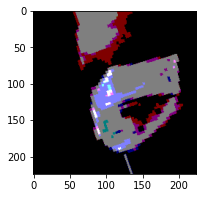

Predicted :  WithMask


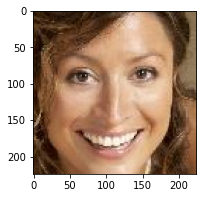

Predicted :  WithoutMask


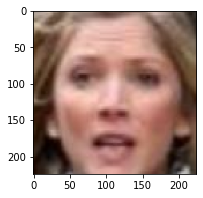

Predicted :  WithoutMask


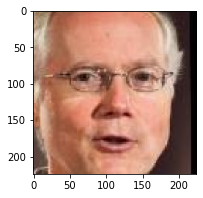

Predicted :  WithoutMask


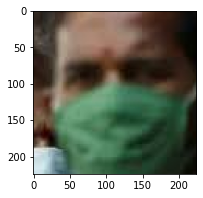

Predicted :  WithMask


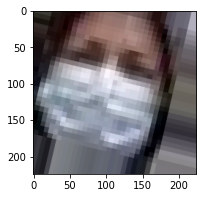

Predicted :  WithMask


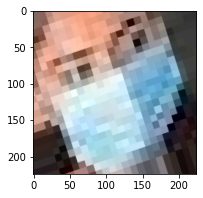

Predicted :  WithMask


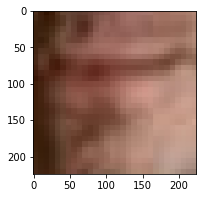

Predicted :  WithMask


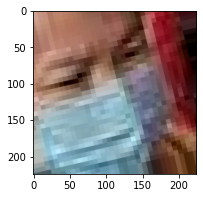

Predicted :  WithMask


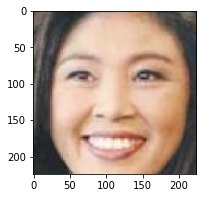

Predicted :  WithoutMask


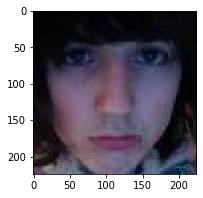

Predicted :  WithoutMask


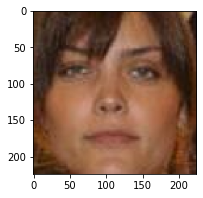

Predicted :  WithoutMask


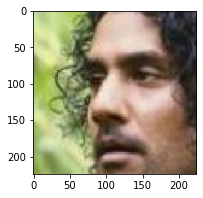

Predicted :  WithoutMask


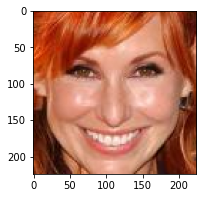

Predicted :  WithoutMask


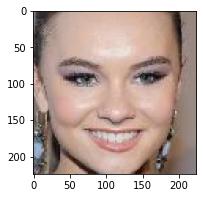

Predicted :  WithoutMask


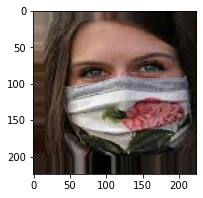

Predicted :  WithMask


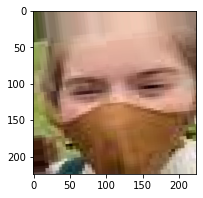

Predicted :  WithMask


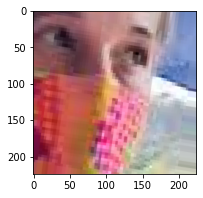

Predicted :  WithMask


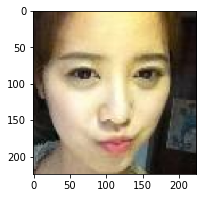

Predicted :  WithoutMask


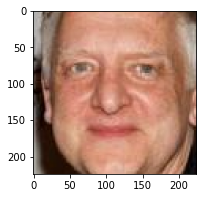

Predicted :  WithoutMask


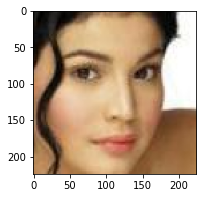

Predicted :  WithoutMask


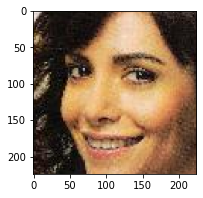

Predicted :  WithoutMask


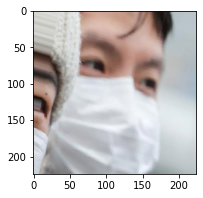

Predicted :  WithMask


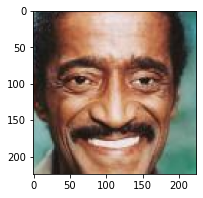

Predicted :  WithoutMask


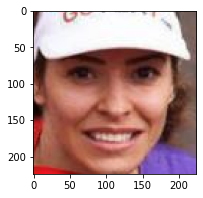

Predicted :  WithoutMask


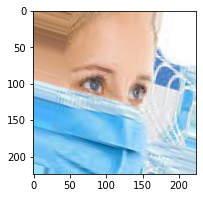

Predicted :  WithMask


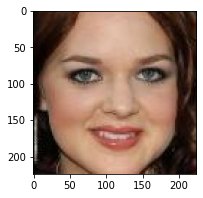

Predicted :  WithoutMask


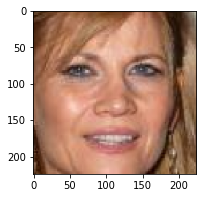

Predicted :  WithoutMask


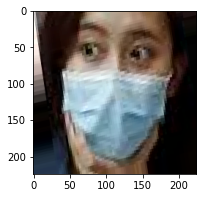

Predicted :  WithMask


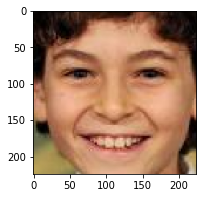

Predicted :  WithoutMask


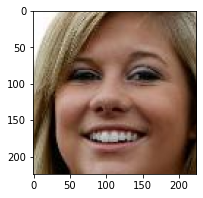

Predicted :  WithoutMask


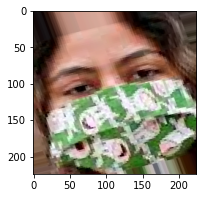

Predicted :  WithMask


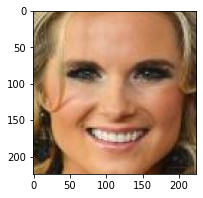

Predicted :  WithoutMask


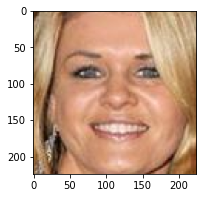

Predicted :  WithoutMask


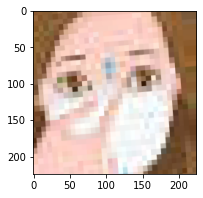

Predicted :  WithMask


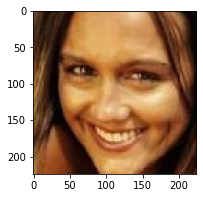

Predicted :  WithoutMask


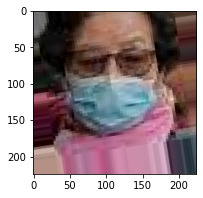

Predicted :  WithMask


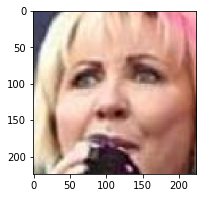

Predicted :  WithoutMask


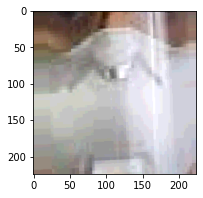

Predicted :  WithMask


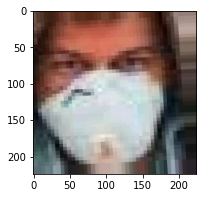

Predicted :  WithMask


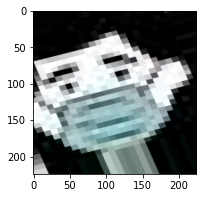

Predicted :  WithMask


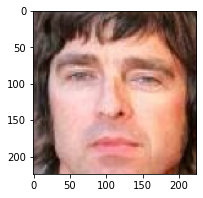

Predicted :  WithoutMask


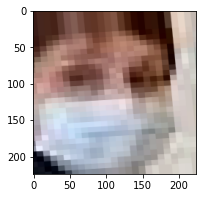

Predicted :  WithMask


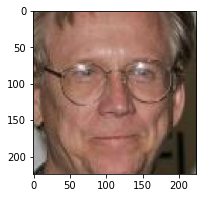

Predicted :  WithoutMask


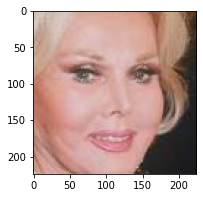

Predicted :  WithoutMask


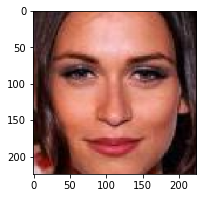

Predicted :  WithoutMask


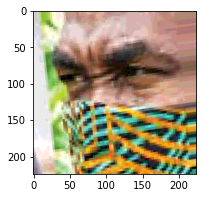

Predicted :  WithMask


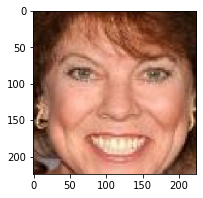

Predicted :  WithoutMask


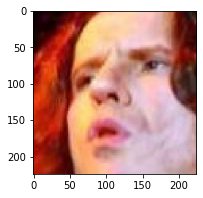

Predicted :  WithoutMask


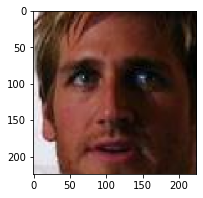

Predicted :  WithoutMask


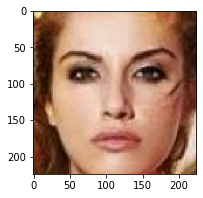

Predicted :  WithoutMask


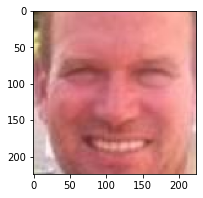

Predicted :  WithoutMask


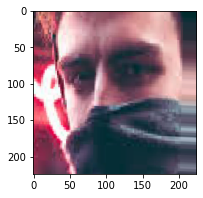

Predicted :  WithMask


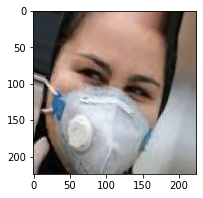

Predicted :  WithMask


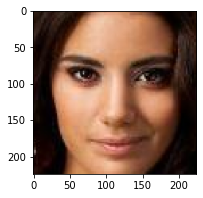

Predicted :  WithoutMask


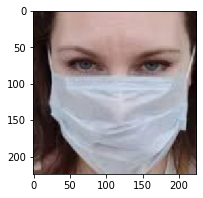

Predicted :  WithMask


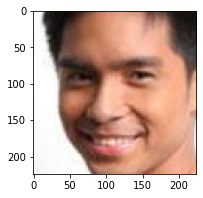

Predicted :  WithoutMask


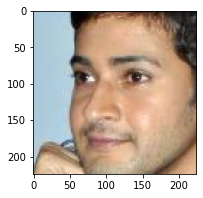

Predicted :  WithoutMask


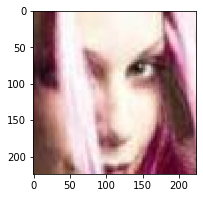

Predicted :  WithoutMask


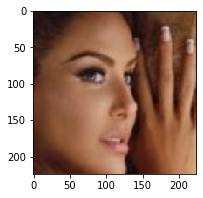

Predicted :  WithoutMask


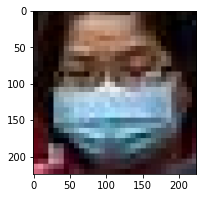

Predicted :  WithMask


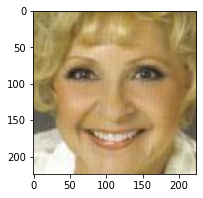

Predicted :  WithoutMask


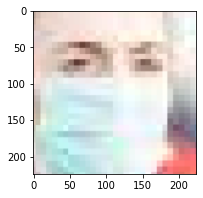

Predicted :  WithMask


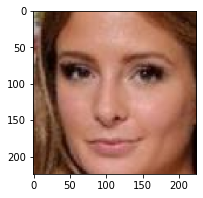

Predicted :  WithoutMask


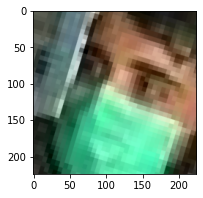

Predicted :  WithMask


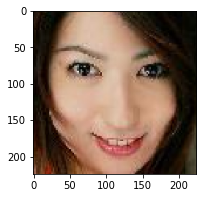

Predicted :  WithoutMask


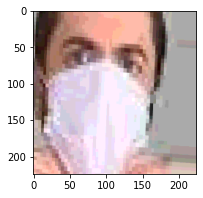

Predicted :  WithMask


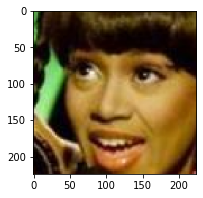

Predicted :  WithoutMask


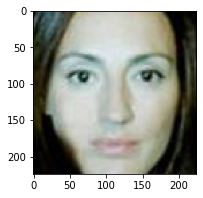

Predicted :  WithoutMask


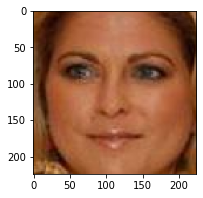

Predicted :  WithoutMask


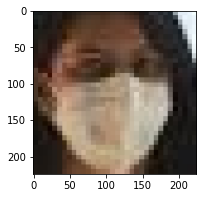

Predicted :  WithMask


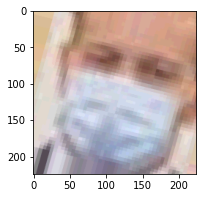

Predicted :  WithMask


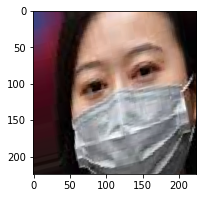

Predicted :  WithMask


In [ ]:
# Classify
for i in range (100):
    predict_class(df_test[i], model)